## Identifying Spike Sequences in Songbird HVC

This notebook shows how to use this package to fit the sequence detection model described in:

> Williams AH, Degleris A, Wang Y, Linderman SW (2020). [Point process models for sequence detection in high-dimensional neural spike trains](https://arxiv.org/abs/2010.04875). *NeurIPS 2020*, Vancouver, CA.

The dataset analyzed in this notebook was originally described and published in:

> Mackevicius EL, Bahle AH, Williams AH, Gu S, Denisenko NI, Goldman MS, Fee MS (2019). [Unsupervised discovery of temporal sequences in high-dimensional datasets, with applications to neuroscience](https://elifesciences.org/articles/38471). *Elife*, 8, e38471. [**[link to original dataset and code.]**](https://github.com/FeeLab/seqNMF)

Note that these are deconvolved spikes from a calcium imaging experiment from one bird.

In [35]:
# Import PPSeq
import PPSeq
const seq = PPSeq

# Other Imports
import PyPlot: plt
import DelimitedFiles: readdlm
import Random
import StatsBase: quantile
using CSV, DataFrames

# Songbird metadata
num_neurons = 51 # use exact number of neurons -_-
max_time = 2*60.0 # use float here

# Randomly permute neuron labels.
# (This hides the sequences, to make things interesting.)
#_p = Random.randperm(num_neurons)

# Load spikes.
spikes = seq.Spike[]
for (n, t) in eachrow(readdlm("data/emmet_data.txt", '\t', Float64, '\n'))
    push!(spikes, seq.Spike(Int(n), t))
end

## Plot a spike raster

Some useful visualization functions are provided for you in `src/utils/visualization.jl`

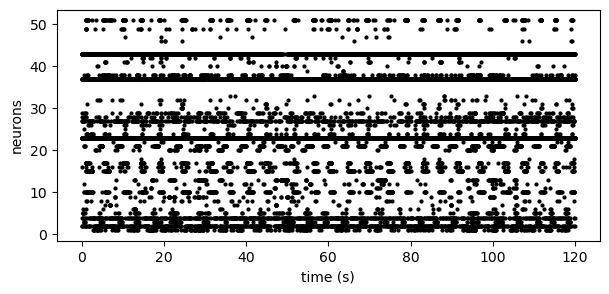

In [36]:
fig = seq.plot_raster(spikes; color="k") # returns matplotlib Figure
fig.set_size_inches([7, 3]);

## Specify PP-Seq model

There are a lot of hyperparameters associated with the pp-Seq model and the MCMC inference procedure. To make things as simple as possible, we create a "config dict" which specifies them all in one place. The table below summarizes the model hyperparameters.

| hyperparameter                | symbol         | Notes |
|:------------------------------|:--------------:|:---------------------|
| num_sequence_types            | $R$            | Number of unique sequence patterns
| seq_type_conc_param           | $\gamma$       | Specifies Dirichlet prior on sequence type probabilities
| seq_event_rate                | $\psi$         | Specifies homogeneous Poisson process for latent events
| mean_event_amplitude          |  N/A           | Specifies $\alpha$ and $\beta$ (supp. eq. #) along with var_event_amplitude
| var_event_amplitude           |  N/A           | Specifies $\alpha$ and $\beta$ (supp. eq. #) along with mean_event_amplitude
| neuron_response_conc_param    | $\varphi$      | Specifies Dirichlet prior on evoked response amplitudes in neural firing rate amplitudes
| neuron_offset_pseudo_obs      | $\kappa$       | Psuedo-observations on mean, Normal-Inverse-Chi-Squared prior
| neuron_width_pseudo_obs       | $\nu$          | Psuedo-observations on variance, Normal-Inverse-Chi-Squared prior 
| neuron_width_prior            | $\sigma^2$     | Variance parameter on Normal-Inverse-Chi-Squared prior
| mean_bkgd_spike_rate          | N/A            | Specifies the mean of Gamma prior on $\lambda_\varnothing$ (specifies $\alpha_\varnothing$ and $\beta_\varnothing$ along with var_bkgd_spike_rate)
| var_bkgd_spike_rate          | N/A            | Specifies the variance of Gamma prior on $\lambda_\varnothing$ (specifies $\alpha_\varnothing$ and $\beta_\varnothing$ along with mean_bkgd_spike_rate)
| bkgd_spikes_conc_param      | $\gamma_\varnothing$ | Specifies Dirichlet prior on relative background firing rates (supp. eq. #)

In [37]:
config = Dict(

    # Model hyperparameters
    :num_sequence_types =>  5,
    :seq_type_conc_param => 1.0,
    :seq_event_rate => 1.0,

    :mean_event_amplitude => 100.0,
    :var_event_amplitude => 1000.0,
    
    :neuron_response_conc_param => 0.1,
    :neuron_offset_pseudo_obs => 1.0,
    :neuron_width_pseudo_obs => 1.0,
    :neuron_width_prior => 0.5,
    
    :num_warp_values => 1,
    :max_warp => 1.0,
    :warp_variance => 1.0,

    :mean_bkgd_spike_rate => 30.0,
    :var_bkgd_spike_rate => 30.0,
    :bkgd_spikes_conc_param => 0.3,
    :max_sequence_length => Inf,
    
    # MCMC Sampling parameters.
    :num_threads => 10,
    :num_anneals => 10,
    :samples_per_anneal => 100,
    :max_temperature => 40.0,
    :save_every_during_anneal => 10,
    :samples_after_anneal => 2000,
    :save_every_after_anneal => 10,
    :split_merge_moves_during_anneal => 10,
    :split_merge_moves_after_anneal => 10,
    :split_merge_window => 1.0,

);

## Train PPSeq model

The `easy_sample!(...)` function is defined in `src/algorithms/easy_sample.jl`. It uses an annealing procedure during the initial MCMC burn-in. See our paper for more details on the specifics of MCMC sampling (Williams et al., 2020).

In [38]:
# Initialize all spikes to background process.
init_assignments = fill(-1, length(spikes))

# Construct model struct (PPSeq instance).
model = seq.construct_model(config, max_time, num_neurons)

# Run Gibbs sampling with an initial annealing period.
results = seq.easy_sample!(model, spikes, init_assignments, config);

(warp_values, warp_log_proportions) = ([1.0], [0.0])
TEMP:  39.99999999999999


┌ Warning: Split merge not implemented for distributed model.
└ @ PPSeq /home/rodrigo/PhD/replay_project/PPSeq.jl/src/algorithms/distributed_gibbs.jl:16


10-20-30-40-50-60-70-80-90-100-Done
TEMP:  26.549315324802276


┌ Warning: Split merge not implemented for distributed model.
└ @ PPSeq /home/rodrigo/PhD/replay_project/PPSeq.jl/src/algorithms/distributed_gibbs.jl:16


10-20-30-40-50-60-70-80-90-100-Done
TEMP:  17.621653605394528


┌ Warning: Split merge not implemented for distributed model.
└ @ PPSeq /home/rodrigo/PhD/replay_project/PPSeq.jl/src/algorithms/distributed_gibbs.jl:16


10-20-30-40-50-60-70-80-90-100-Done
TEMP:  11.696070952851464


┌ Warning: Split merge not implemented for distributed model.
└ @ PPSeq /home/rodrigo/PhD/replay_project/PPSeq.jl/src/algorithms/distributed_gibbs.jl:16


10-20-30-40-50-60-70-80-90-100-Done
TEMP:  7.763066894712855


┌ Warning: Split merge not implemented for distributed model.
└ @ PPSeq /home/rodrigo/PhD/replay_project/PPSeq.jl/src/algorithms/distributed_gibbs.jl:16


10-20-30-40-50-60-70-80-90-100-Done
TEMP:  5.152602771881631


┌ Warning: Split merge not implemented for distributed model.
└ @ PPSeq /home/rodrigo/PhD/replay_project/PPSeq.jl/src/algorithms/distributed_gibbs.jl:16


10-20-30-40-50-60-70-80-90-100-Done
TEMP:  3.419951893353394


┌ Warning: Split merge not implemented for distributed model.
└ @ PPSeq /home/rodrigo/PhD/replay_project/PPSeq.jl/src/algorithms/distributed_gibbs.jl:16


10-20-30-40-50-60-70-80-90-100-Done
TEMP:  2.269934530307346


┌ Warning: Split merge not implemented for distributed model.
└ @ PPSeq /home/rodrigo/PhD/replay_project/PPSeq.jl/src/algorithms/distributed_gibbs.jl:16


10-20-30-40-50-60-70-80-90-100-Done
TEMP:  1.5066301902946675


┌ Warning: Split merge not implemented for distributed model.
└ @ PPSeq /home/rodrigo/PhD/replay_project/PPSeq.jl/src/algorithms/distributed_gibbs.jl:16


10-20-30-40-50-60-70-80-90-100-Done
TEMP:  1.0


┌ Warning: Split merge not implemented for distributed model.
└ @ PPSeq /home/rodrigo/PhD/replay_project/PPSeq.jl/src/algorithms/distributed_gibbs.jl:16


10-20-30-40-50-60-70-80-90-100-Done


┌ Warning: Split merge not implemented for distributed model.
└ @ PPSeq /home/rodrigo/PhD/replay_project/PPSeq.jl/src/algorithms/distributed_gibbs.jl:16


10-20-30-40-50-60-70-80-90-100-110-120-130-140-150-160-170-180-190-200-210-220-230-240-250-260-270-280-290-300-310-320-330-340-350-360-370-380-390-400-410-420-430-440-450-460-470-480-490-500-510-520-530-540-550-560-570-580-590-600-610-620-630-640-650-660-670-680-690-700-710-720-730-740-750-760-770-780-790-800-810-820-830-840-850-860-870-880-890-900-910-920-930-940-950-960-970-980-990-1000-1010-1020-1030-1040-1050-1060-1070-1080-1090-1100-1110-1120-1130-1140-1150-1160-1170-1180-1190-1200-1210-1220-1230-1240-1250-1260-1270-1280-1290-1300-1310-1320-1330-1340-1350-1360-1370-1380-1390-1400-1410-1420-1430-1440-1450-1460-1470-1480-1490-1500-1510-1520-1530-1540-1550-1560-1570-1580-1590-1600-1610-1620-1630-1640-1650-1660-1670-1680-1690-1700-1710-1720-1730-1740-1750-1760-1770-1780-1790-1800-1810-1820-1830-1840-1850-1860-1870-1880-1890-1900-1910-1920-1930-1940-1950-1960-1970-1980-1990-2000-Done


## Plot results

#### Plot raster plot with labeled sequences

In [12]:
struct Spike
    neuron::Int64
    timestamp::Float64
end

struct EventSummaryInfo
    assignment_id::Int64
    timestamp::Float64
    seq_type::Int64
    seq_warp::Float64
    amplitude::Float64
end

In [13]:
function plot_raster(spikes::Vector{Spike}; kwargs...)

    # Create figure and allocate space.
    fig = plt.figure()
    _x, _y = zeros(length(spikes)), zeros(length(spikes))

    # Plot raster and return.
    for (i, s) in enumerate(spikes)
        _x[i] = s.timestamp
        _y[i] = s.neuron
    end
    (length(fig.axes) < 1) && fig.add_subplot(1, 1, 1)
    fig.axes[1].scatter(_x, _y; s=4, kwargs...)
    fig.axes[1].set_ylabel("neurons")
    fig.axes[1].set_xlabel("time (s)")
    return fig
end

function plot_raster(
        spikes::Vector{PPSeq.Spike},
        events::Vector{PPSeq.EventSummaryInfo},
        spike_assignments::Vector{Int64},
        neuron_order::Vector{Int64};
        color_cycle=["#E41A1C",
                     "#377EB8",
                     "#4DAF4A",
                     "#984EA3",
                     "#FF7F00",
                     "#FFFF33",
                     "#A65628",
                     "#F781BF"],
        background=1,
        kwargs...
    )

    fig = plt.figure()
    _x, _y = AbstractFloat[], AbstractFloat[]
    _c = String[]
    
    
#     _alpha = zeros(length(spikes))

    typemap = Dict((e.assignment_id => e.seq_type) for e in events)
    yidx = sortperm(neuron_order)
    
    if background == 1
        for (i, s) in enumerate(spikes)
            push!(_x, s.timestamp)
            push!(_y, yidx[s.neuron])
            if spike_assignments[i] == -1
                push!(_c, "k")
            else
                k = typemap[spike_assignments[i]]
                col_ind = 1 + ((k - 1) % length(color_cycle))
                push!(_c, color_cycle[col_ind])
            end
        end
        
        (length(fig.axes) < 1) && fig.add_subplot(1, 1, 1)
        fig.axes[1].scatter(_x, _y; c=_c, s=4, kwargs...)
        fig.axes[1].set_ylabel("neurons")
        fig.axes[1].set_xlabel("time (s)")
        return fig        
    end
    
    for (i, s) in enumerate(spikes)
        if spike_assignments[i] != -1
            
            #_x[i] = s.timestamp
            push!(_x, s.timestamp)
            #_y[i] = yidx[s.neuron]
            push!(_y, yidx[s.neuron])

#         if spike_assignments[i] == -1
#             # continue
#             push!(_c, "white")
#             _alpha[i] = 0.0
#             #push!(_alpha, 0.0)
#         else
            k = typemap[spike_assignments[i]]
            col_ind = 1 + ((k - 1) % length(color_cycle))
            push!(_c, color_cycle[col_ind])
#             _alpha[i] = 1.0
#             #push!(_alpha, 1.0)
        end
    end

    (length(fig.axes) < 1) && fig.add_subplot(1, 1, 1)
    fig.axes[1].scatter(_x, _y; c=_c, s=4, kwargs...)
    fig.axes[1].set_ylabel("neurons")
    fig.axes[1].set_xlabel("time (s)")
    return fig
end

plot_raster (generic function with 2 methods)

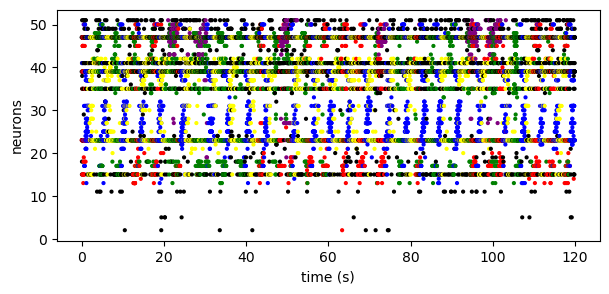

In [40]:
# Grab the final MCMC sample
final_globals = results[:globals_hist][end]
final_events = results[:latent_event_hist][end]
final_assignments = results[:assignment_hist][:, end]

# Helpful utility function that sorts the neurons to reveal sequences.
neuron_ordering = seq.sortperm_neurons(final_globals)

# Plot model-annotated raster.
fig = plot_raster(
    spikes,
    final_events,
    final_assignments,
    neuron_ordering,
    color_cycle=["red", "blue", "green", "yellow", "purple","k"], # colors for each sequence type can be modified.
    background=1
)
fig.set_size_inches([7, 3]);

In [71]:
results[:assignment_hist]

19039×200 Array{Int64,2}:
   6   -1    6    6    6   -1   -1    6  …    1    7   -1    7    1    1    1
   6    6    6    6   -1    6    6    6       1    1    1   -1    7    6    6
   6    6    6    6   -1    6    6    6       6    7    7    7    1   -1    7
   6    6    6    6    6    6    6    6       7    6    7    1    7    1    6
   6    6    6    6    6    6    6    6       1    6    6    6    6    7    6
   6    6    6    6    6    6    6    6  …    6    6    6    6    7   -1    6
   6   -1    6   -1    6    6    6    6       6    6    6    6   -1    7    7
   6    6    6   -1    6    6    6    6       6    6    6    6    6    6    6
   6    6    6    6    6    6    6    6       6   -1   -1    6    6    6    1
   6   -1   -1   -1   -1    6    6   -1       6    6    6   -1    6    6    1
   6    6    6    6    6   -1   -1    6  …    6    6   -1   -1    1   -1    7
  -1    6   -1   -1   -1   -1   -1   -1      -1   -1   -1   -1   -1   -1    2
   5    5    5    5    5    5    5    

In [66]:
results

Dict{Symbol,Array} with 10 entries:
  :anneal_latent_event_hist => Array{PPSeq.EventSummaryInfo,1}[[EventSummaryInf…
  :assignment_hist          => [6 -1 … 1 1; 6 6 … 6 6; … ; 130 130 … 130 130; 1…
  :final_assignments        => [1, 6, 7, 6, 6, 6, 7, 6, 1, 1  …  129, 129, 130,…
  :globals_hist             => PPSeq.SeqGlobals[SeqGlobals([-1.62844, -1.66245,…
  :anneal_globals_hist      => PPSeq.SeqGlobals[SeqGlobals([-2.35249, -1.72686,…
  :latent_event_hist        => Array{PPSeq.EventSummaryInfo,1}[[EventSummaryInf…
  :log_p_hist               => [75589.7, 75820.4, 75282.9, 75265.1, 75546.2, 75…
  :anneal_log_p_hist        => [76097.3, 77649.6, 77851.0, 77528.8, 77550.8, 77…
  :anneal_assignment_hist   => [6 1 … -1 -1; 6 1 … -1 -1; … ; 140 149 … 130 130…
  :initial_assignments      => [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1  …  -1, …

In [76]:
conv_anneal_latent_event_hist = convert(DataFrame, results[:assignment_hist])
converted_assigment_hist = convert(DataFrame, results[:assignment_hist])

┌ Warning: `convert(::Type{DataFrame}, A::AbstractMatrix)` is deprecated, use `DataFrame(Tables.table(A, header = Symbol.(:x, axes(A, 2))))` instead.
│   caller = top-level scope at In[76]:1
└ @ Core In[76]:1


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,6,-1,6,6,6,-1,-1,6,-1,-1,6,6
2,6,6,6,6,-1,6,6,6,6,6,6,6
3,6,6,6,6,-1,6,6,6,6,-1,-1,6
4,6,6,6,6,6,6,6,6,-1,-1,6,-1
5,6,6,6,6,6,6,6,6,6,6,6,6
6,6,6,6,6,6,6,6,6,6,6,6,6
7,6,-1,6,-1,6,6,6,6,6,6,6,-1
8,6,6,6,-1,6,6,6,6,6,6,6,6
9,6,6,6,6,6,6,6,6,-1,6,6,6


In [75]:
CSV.write("great_sequences.csv", converted_assigment_hist, writeheader=true)

"great_sequences.csv"

In [81]:
results[:anneal_latent_event_hist][end][1].field

ErrorException: [91mtype EventSummaryInfo has no field field[39m

In [41]:
CSV.write("great_sequences.csv", results, writeheader=true)

┌ Warning: `writeheader=true` is deprecated in favor of `header=true`
│   caller = ip:0x0
└ @ Core :-1


ArgumentError: [91mArgumentError: row size (13029506) too large for writing buffer (4194304), pass a larger value to `bufsize` keyword argument[39m

#### Plot log-likelihood over MCMC samples

The log-likelihoods during the annealing period are stored in `results[:anneal_log_p_hist]`.

The log-likelihoods during the post-anneal period are stored in `results[:log_p_hist]`.

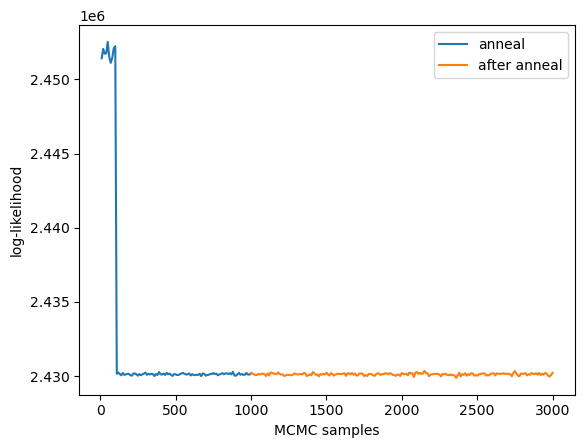

In [15]:
seq.plot_log_likes(config, results);

#### Plot number of latent events (i.e. number of sequences) over MCMC samples

The latent events during the annealing period are stored in `results[:anneal_latent_event_hist]`.

The log-likelihoods during the post-anneal period are stored in `results[:latent_event_hist]`.

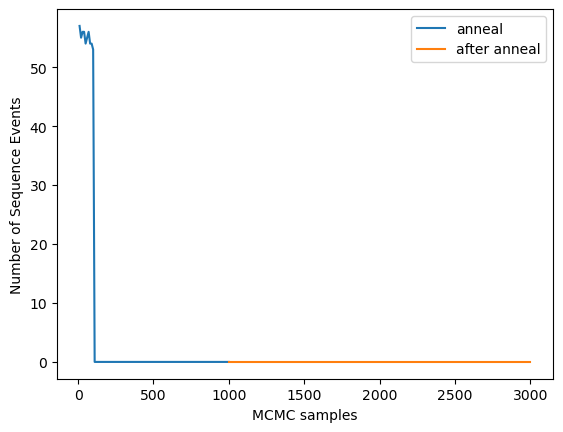

In [16]:
seq.plot_num_seq_events(config, results);

### Plot Firing Rates

Now we'll plot the firing rate estimate of the model on the last MCMC sample.

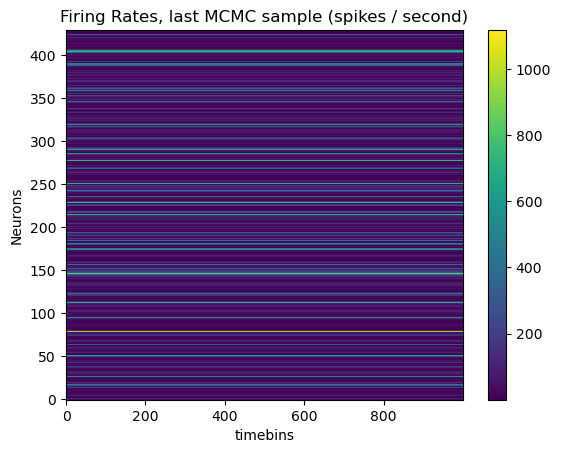

In [17]:
# Create discrete time grid.
num_timebins = 1000
dt = max_time / num_timebins
timebins = collect((0.5 * dt):dt:max_time)

# Compute a matrix firing rates (num_neurons x num_timebins)
F = seq.firing_rates(
    final_globals,
    final_events,
    timebins
)

# Plot firing rates as a heatmap
plt.imshow(F[neuron_ordering, :]; aspect="auto", origin="lower")
plt.title("Firing Rates, last MCMC sample (spikes / second)")
plt.ylabel("Neurons")
plt.xlabel("timebins")
plt.colorbar();

This is somewhat hard to interpret because neurons have very different peak firing rates. To see the sequences better, we can re-scale the firing rates to range between zero and one for each neuron.

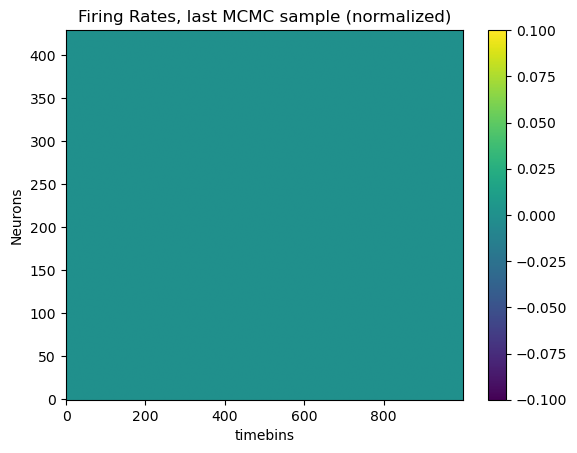

In [18]:
F_nrm = copy(F)
for n in 1:num_neurons
    F_nrm[n, :] .-= minimum(F[n, :])
    F_nrm[n, :] ./= maximum(F[n, :])
end

plt.title("Firing Rates, last MCMC sample (normalized)")
plt.ylabel("Neurons")
plt.xlabel("timebins")
plt.imshow(F_nrm[neuron_ordering, :]; aspect="auto", origin="lower")
plt.colorbar();

### Plot Expected Firing Rates Under the Posterior

Rather than just plotting the final sample, we can average the firing rate estimate over all MCMC samples in the post-annealing epoch.

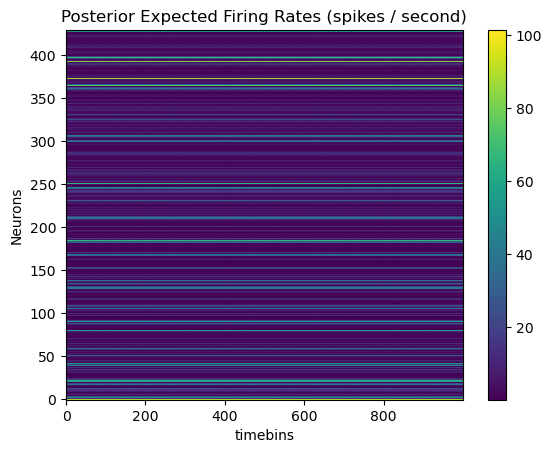

In [18]:
F_avg = zeros(num_neurons, num_timebins)

for (G, E) in zip(results[:globals_hist], results[:latent_event_hist])
    F_avg += seq.firing_rates(G, E, timebins)
end
F_avg ./= length(results[:globals_hist])

# Plot average firing rates as a heatmap
plt.imshow(F_avg[neuron_ordering, :]; aspect="auto", origin="lower")
plt.title("Posterior Expected Firing Rates (spikes / second)")
plt.ylabel("Neurons")
plt.xlabel("timebins")
plt.colorbar();

As before, this is somewhat difficult to visually inspect because the neurons have different firing rate magnitudes. Again, we can normalize the firing rates to range between zero and one.

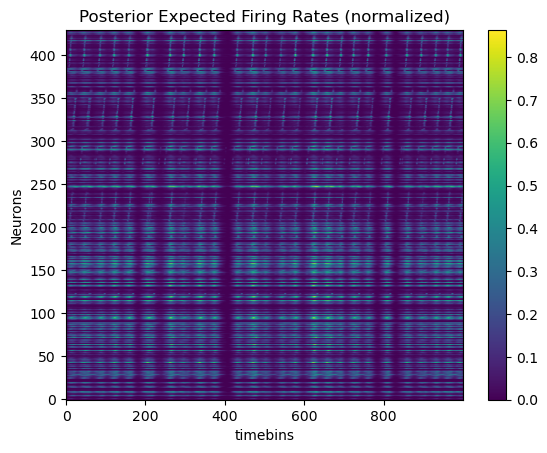

In [19]:
F_avg_nrm = copy(F_avg)
for n in 1:num_neurons
    F_avg_nrm[n, :] .-= minimum(F_avg[n, :])
    F_avg_nrm[n, :] ./= maximum(F_avg[n, :])
end

# Plot average firing rates as a heatmap
plt.imshow(F_avg_nrm[neuron_ordering, :]; aspect="auto", origin="lower")
plt.title("Posterior Expected Firing Rates (normalized)")
plt.ylabel("Neurons")
plt.xlabel("timebins")
plt.colorbar();